In [1]:
import pandas as pd
import numpy as np
from astropy.io.votable.tree import resolve_id
from matplotlib import pyplot as plt

from pyaw import swarm, utils_spectral,utils_preprocess
from pyaw.swarm import Swarm
from scipy.spatial.transform import Rotation as R
from scipy.signal import stft

import importlib


importlib.reload(swarm)
importlib.reload(utils_spectral)
importlib.reload(utils_preprocess)

<module 'pyaw.utils_preprocess' from 'D:\\cleo\\master\\pyaw\\pyaw\\utils_preprocess.py'>

In [2]:
fp_e = r"\\Diskstation1\file_three\aw\swarm\B\efi16\sw_efi16B_20140219T0231_20140219T0241_0.pkl"
fp_b = r"\\Diskstation1\file_three\aw\swarm\B\vfm50\sw_vfm50B_20140219T0231_20140219T0241_0.pkl"

In [3]:
swarm_e = Swarm(fp_e, 'efi16','20140219T0231','20140219T0241')
swarm_b = Swarm(fp_b, 'vfm50','20140219T0231','20140219T0241')
df_e = swarm_e.df
df_b = swarm_b.df

self.df['eh_sc1'] set nan:
1340
datetime
2014-02-19 02:32:23.506750107    31.041510
2014-02-19 02:32:42.693749905    31.127319
2014-02-19 02:32:42.818749905    30.728220
2014-02-19 02:32:50.881750107    31.116058
2014-02-19 02:34:40.193749905    31.344532
                                   ...    
2014-02-19 02:38:05.006750107   -18.074432
2014-02-19 02:38:05.068749905   -17.078434
2014-02-19 02:38:05.193749905   -16.934528
2014-02-19 02:38:05.318749905   -17.287550
2014-02-19 02:38:05.443749905   -17.266350
Name: eh_sc1, Length: 1340, dtype: float32

self.df['eh_sc2'] set nan:
1884
datetime
2014-02-19 02:36:21.443749905   -68.049850
2014-02-19 02:36:21.568749905   -67.732269
2014-02-19 02:36:24.318749905   -67.709724
2014-02-19 02:36:25.443749905   -68.185638
2014-02-19 02:36:25.568749905   -68.592323
                                   ...    
2014-02-19 02:38:45.506750107   -68.523720
2014-02-19 02:38:45.943749905   -67.859322
2014-02-19 02:38:46.131750107   -68.945580
2014-02-19 02:

In [4]:
# get quaternions
B_VFM = df_b['B_VFM']
B_NEC = df_b['B_NEC']
# Preallocate
n_iterations = len(B_VFM)
array_shape = (4,)  # Shape of each array
quaternions = np.empty((n_iterations, *array_shape))
for i,vector_a,vector_b in zip(range(n_iterations),B_VFM,B_NEC):
    # Compute the rotation aligning vector_b to vector_a
    rotation, _ = R.align_vectors([vector_a], [vector_b])

    # Extract the quaternion (in scalar-last format by default)
    quaternion = rotation.as_quat()
    quaternions[i] = quaternion
df_b['quaternions'] = quaternions.tolist()

In [5]:
# test quaternions
rotation = R.from_quat(df_b['quaternions'].iloc[0])
rotated_vector = rotation.apply(df_b['B_NEC'].iloc[0])
rotated_vector,df_b['B_VFM'].iloc[0]

(array([44973.36914161, -2114.54320196, 11356.85901051]),
 array([44973.3691, -2114.5432, 11356.859 ]))

# compare to the paper
# pyIGRF output localization

In [6]:
# IGRF B
IGRF_B = pd.read_pickle(r'pyaw/pyIGRF/wu2020_IGRF_B_20140219T0231_20140219T0241.pkl')

In [7]:
IGRF_B['Combined'] = IGRF_B[['IGRF_B_N', 'IGRF_B_E', 'IGRF_B_C']].apply(lambda row: row.values, axis=1)

In [8]:
IGRF_B_NEC = IGRF_B['Combined']

In [9]:
igrf_b_vfm_ls = []
for igrf_b_nec,quaternion in zip(IGRF_B_NEC,df_b['quaternions']):
    rotation = R.from_quat(quaternion)
    igrf_b_vfm_ls.append(rotation.apply(igrf_b_nec))

In [10]:
df_b['IGRF_B_VFM'] = igrf_b_vfm_ls

In [11]:
By = df_b['B_VFM'].apply(lambda row: row[1])
model_By = df_b['IGRF_B_VFM'].apply(lambda row: row[1])
residual_By = By - model_By

<Axes: xlabel='datetime'>

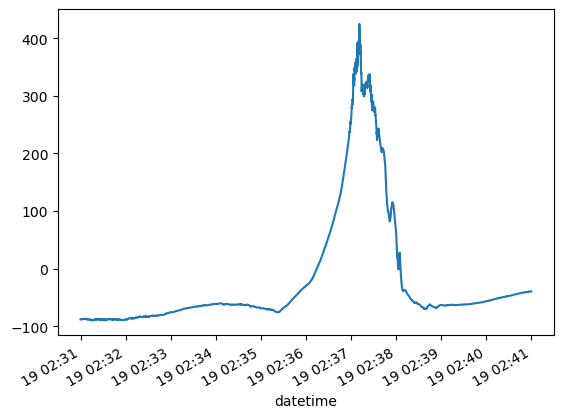

In [12]:
residual_By.plot()

<Axes: xlabel='datetime'>

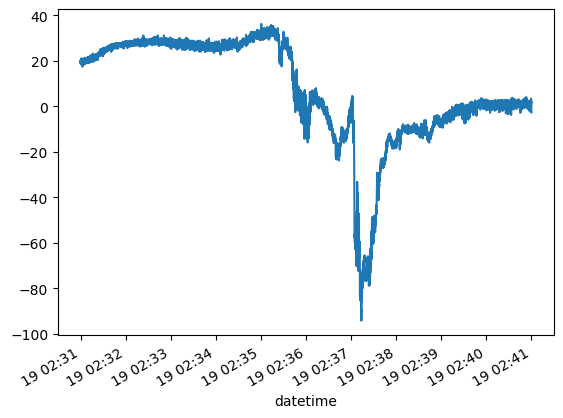

In [13]:
df_e['Ehx'].plot()

In [14]:
resisual_By_align = utils_preprocess.align_high2low(residual_By, df_e['Ehx'])

In [15]:
# spec_by = utils_spectral.Spectrogram(resisual_By_align,16)

In [16]:
# spec_by.plot_spectrogram()

In [17]:
# freqs, times, Sxx = stft
# plt.figure()
# plt.pcolormesh(times, freqs, 10 * np.log10(Sxx),vmin=-10,vmax=10)
# plt.colorbar(label='csd module')
# plt.xlabel('UT Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.title('Cross-Spectrogram module between Signal 1 and Signal 2')
# plt.show()

In [18]:
# spec_ex = utils_spectral.Spectrogram(df_e['Ehx'],16)

In [19]:
# from matplotlib import pyplot as plt
#
# freqs, times, Sxx = spec_ex.get_spectrogram()
# plt.figure()
# plt.pcolormesh(times, freqs, 10 * np.log10(Sxx),vmin=-10,vmax=10)
# plt.colorbar(label='csd module')
# plt.xlabel('UT Time (s)')
# plt.ylabel('Frequency (Hz)')
# plt.title('Cross-Spectrogram module between Signal 1 and Signal 2')
# plt.show()

In [20]:
# from scipy.signal import spectrogram, coherence
#
# window='hann'
# window_length=4
# fs = 16
# nperseg = int(window_length * fs)  # 每个窗的采样点数
# noverlap = nperseg // 2  # 50%重叠
#
#
# f, t_stft, S_By = spectrogram(resisual_By_align, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
# _, _, S_Ex = spectrogram(df_e['Ehx'], fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

In [21]:
window='hann'
window_length=4
fs = 16
nperseg = int(window_length * fs)  # 每个窗的采样点数
noverlap = nperseg // 2  # 50%重叠

In [22]:
f, t_stft, S_By = stft(resisual_By_align, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,scaling='psd',padded=False,boundary=None)
_, _, S_Ex = stft(df_e['Ehx'], fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,scaling='psd',padded=False,boundary=None)

In [23]:
# Assume `resisual_By_align.index` is a pd.Timestamp type
start_time = resisual_By_align.index[0]  # Get the start time from the index

# Convert `t_stft` to pd.Timestamp
t_stft_timestamps = pd.to_datetime(t_stft, unit='s', origin=start_time)

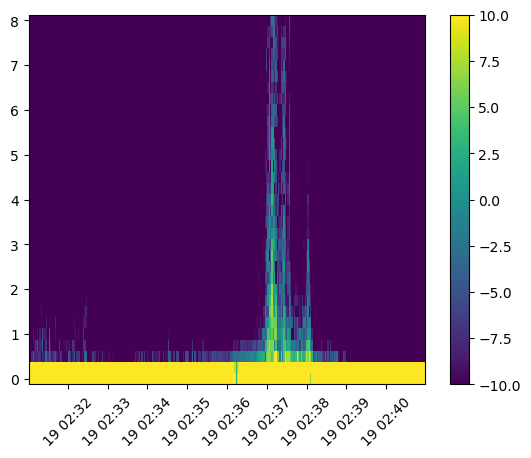

In [24]:
plt.figure()
plt.pcolormesh(t_stft_timestamps, f, 10 * np.log10(np.abs(S_By)),vmin=-10,vmax=10)
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

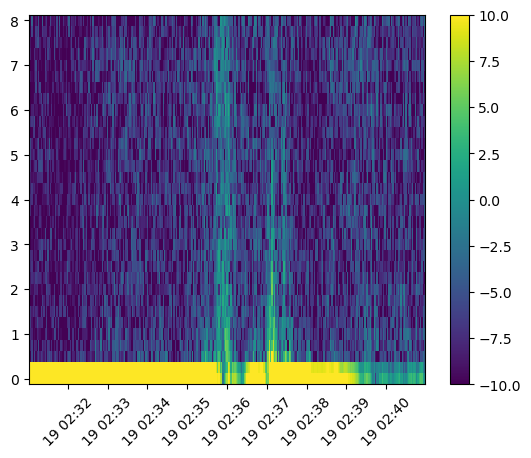

In [25]:
plt.figure()
plt.pcolormesh(t_stft_timestamps, f, 10 * np.log10(np.abs(S_Ex)),vmin=-10,vmax=10)
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

In [26]:
from scipy.signal import spectrogram
f_spec, t_stft_spec, S_By_spec = spectrogram(resisual_By_align, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, S_Ex_spec = spectrogram(df_e['Ehx'], fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

In [27]:
# Assume `resisual_By_align.index` is a pd.Timestamp type
start_time = resisual_By_align.index[0]  # Get the start time from the index

# Convert `t_stft` to pd.Timestamp
t_stft_timestamps_spec = pd.to_datetime(t_stft_spec, unit='s', origin=start_time)

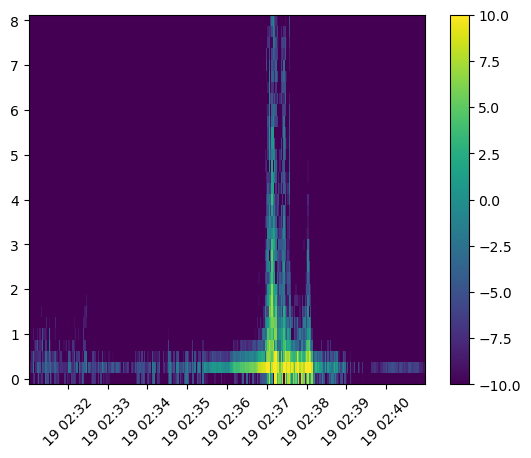

In [28]:
plt.figure()
plt.pcolormesh(t_stft_timestamps_spec, f_spec, 10 * np.log10(np.abs(S_By_spec)),vmin=-10,vmax=10)
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

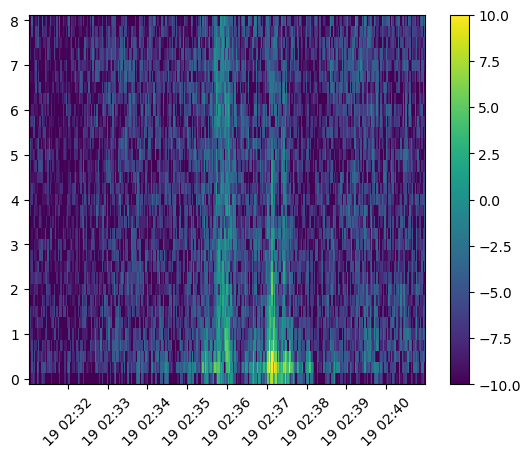

In [29]:
plt.figure()
plt.pcolormesh(t_stft_timestamps_spec, f_spec, 10 * np.log10(np.abs(S_Ex_spec)),vmin=-10,vmax=10)
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

In [30]:
# Compute CPSD and Coherency
S_By_Ex_spec = S_By_spec * np.conj(S_Ex_spec)  # Cross-spectral density
CPSD_spec = np.abs(S_By_Ex_spec)  # Magnitude of CPSD

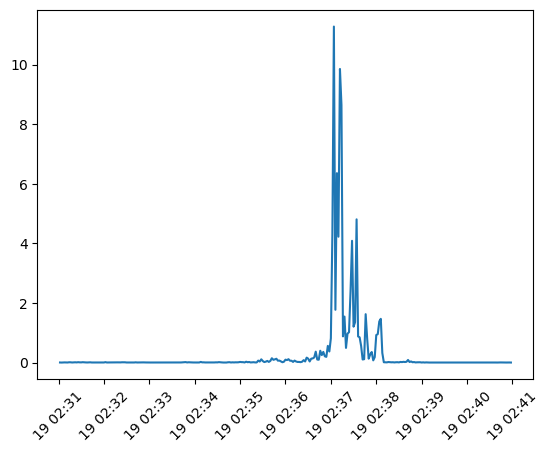

In [31]:
plt.figure()
plt.plot(t_stft_timestamps_spec,CPSD_spec.mean(axis=0))
plt.xticks(rotation=45)
plt.show()

In [32]:
def split_array(data):
    # Split the array
    step = 11
    result = [data[:, i:i + step] for i in range(0, data.shape[1] - step, step)]
    # Add the remaining columns to the last segment
    remainder = data[:, step * len(result):]
    if remainder.size > 0:
        if len(result) > 0:
            # Append remaining columns to the last split
            result[-1] = np.hstack((result[-1], remainder))
        else:
            # If there's no initial split, the remainder is the only result
            result.append(remainder)
    # # Convert result to a NumPy array (optional)
    # print(f"Number of resulting arrays: {len(result)}")
    # for idx, arr in enumerate(result):
    #     print(f"Shape of array {idx}: {arr.shape}")
    return result


In [33]:
S_By_Ex_split_spec = split_array(S_By_Ex_spec)

In [34]:
nominator1ls = split_array(np.abs(S_Ex_spec ** 2))
nominator2ls = split_array(np.abs(S_By_spec ** 2))

In [35]:
coherences_spec = []
for i in range(len(S_By_Ex_split_spec)):
    denominator = sum(S_By_Ex_split_spec[i]) / len(S_By_Ex_split_spec[i])
    nominator = np.sqrt(sum(nominator1ls[i]) / len(nominator1ls[i])) * np.sqrt(sum(nominator2ls[i]) / len(nominator2ls[i]))
    print("denominator:",denominator)
    print("nominator:",nominator)
    print("denominator/nominator",denominator/nominator)
    print("coherency:",sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))
    print("----------------------------------------")
    coherences_spec.append(sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))

denominator: [-2.20481509e-03-7.86556882e-04j  9.05048358e-06+2.67394655e-05j
 -1.58985185e-03-1.83652942e-03j  2.99808906e-03+1.21336794e-03j
 -8.85334329e-05+9.15925708e-04j  1.22488953e-04+1.88758232e-03j
 -1.08391065e-03+5.37746855e-03j  6.09381581e-03+2.08298253e-03j
 -4.63384719e-04-9.58976532e-04j -5.71966325e-04-3.81508586e-04j
 -1.70351490e-03+6.83044635e-03j]
nominator: [0.0085086  0.00416127 0.00744289 0.01501284 0.00834192 0.00928498
 0.01803681 0.01952093 0.01245198 0.00988149 0.02226161]
denominator/nominator [-0.25912788-0.09244259j  0.00217493+0.0064258j  -0.21360687-0.24674959j
  0.19970162+0.080822j   -0.01061308+0.10979798j  0.01319216+0.20329417j
 -0.06009437+0.29813859j  0.31216831+0.10670508j -0.03721374-0.07701399j
 -0.05788258-0.03860839j -0.07652253+0.30682623j]
coherency: 0.20391918582919885
----------------------------------------
denominator: [-2.68357594e-03+0.00218838j -5.66531432e-03-0.00459372j
 -5.38389467e-03-0.00045027j -3.55562908e-03+0.00248245j
 -4

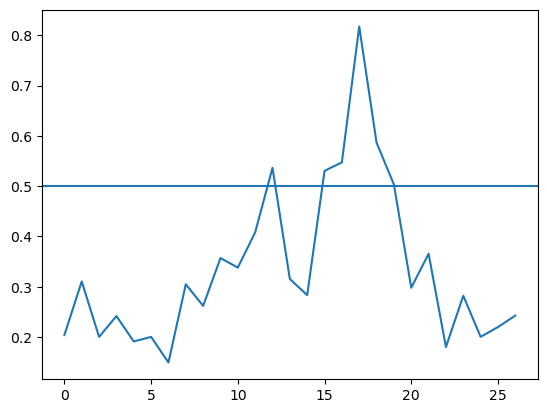

In [36]:
plt.figure()
plt.plot(coherences_spec)
plt.axhline(0.5)
plt.show()

In [45]:
b_dynamic = resisual_By_align.loc['20140219T023700':'20140219T023730']
e_dynamic = df_e['Ehx'].loc['20140219T023700':'20140219T023730']

In [46]:
f_synamic, t_stft_dynamic, S_By_dynamic = spectrogram(b_dynamic, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, S_Ex_dynamic = spectrogram(e_dynamic, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

In [48]:
from pyaw.paras import mu0
impedance_magnitude_dynamic = np.abs(mu0*S_Ex_dynamic/S_By_dynamic) * 1e3
impedance_magnitude_dynamic

array([[2.23849798e-03, 2.28644009e-04, 8.69920443e-03, 5.22675224e-03,
        2.39758489e-02, 1.73701303e-04, 4.40061575e-04, 6.67153103e-04,
        5.28605724e-04, 6.57818380e-04, 1.47961541e-03, 5.27249684e-04,
        2.70118738e-02, 7.06340978e-04],
       [5.61632419e-04, 2.20396145e-03, 2.17739357e-03, 1.86002765e-03,
        1.84730227e-04, 4.53959487e-04, 3.50752421e-04, 5.32768975e-04,
        5.58095884e-04, 7.71115439e-04, 5.31555260e-04, 5.47371547e-04,
        5.04321471e-04, 7.37841741e-04],
       [1.06016303e-03, 3.32895456e-03, 8.44060511e-04, 4.22435583e-03,
        1.75344020e-03, 4.38536372e-04, 4.96579447e-04, 9.88055314e-05,
        7.98598819e-04, 6.46936210e-04, 3.17451878e-04, 1.12537935e-03,
        8.44576678e-04, 7.34097413e-04],
       [5.69078701e-04, 1.28692374e-03, 5.62070377e-04, 8.19651860e-04,
        1.54278179e-03, 3.51211000e-03, 1.03111188e-03, 1.51663911e-03,
        1.53639205e-03, 6.82784810e-04, 6.50045617e-04, 1.26812106e-03,
        2.015

In [49]:
impedance_magnitude_dynamic.max(),impedance_magnitude_dynamic.min()

(0.11705896715361079, 8.742448332198029e-05)

In [50]:
b_static = resisual_By_align.loc['20140219T023430':'20140219T023500']
e_static = df_e['Ehx'].loc['20140219T023430':'20140219T023500']

In [51]:
f_static, t_stft_static, S_By_static = spectrogram(b_static, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')
_, _, S_Ex_static = spectrogram(e_static, fs=fs,window=window, nperseg=nperseg, noverlap=noverlap,mode='complex')

In [52]:
from pyaw.paras import mu0
impedance_magnitude_static = np.abs(mu0*S_Ex_static/S_By_static) * 1e3
impedance_magnitude_static

array([[1.90827906e-03, 1.31630561e-04, 1.05046440e-04, 5.07650375e-03,
        9.83985130e-06, 7.22987394e-04, 1.71975263e-05, 4.31353888e-04,
        2.87095135e-03, 1.80226480e-03, 2.65224751e-03, 8.60900362e-03,
        8.23925045e-04, 7.27793045e-06],
       [1.41955596e-03, 3.22626428e-04, 8.85752234e-04, 8.41885349e-04,
        4.16888348e-04, 1.18802167e-03, 7.25175580e-04, 7.43239430e-04,
        1.81959943e-03, 1.96885318e-03, 1.46950986e-03, 1.47162635e-03,
        3.48346007e-03, 9.90927797e-04],
       [1.94182681e-04, 8.22867897e-04, 1.37749712e-03, 3.09206971e-03,
        3.44574273e-04, 4.95774212e-03, 6.49100666e-04, 9.98858502e-04,
        1.41887332e-03, 1.94642989e-03, 5.53377604e-03, 2.50057837e-03,
        8.46339623e-03, 1.42122217e-03],
       [1.54677327e-03, 5.67889363e-03, 1.29789113e-02, 1.17026529e-03,
        3.04216244e-03, 5.40316895e-03, 2.97571971e-03, 4.87038705e-03,
        5.92833071e-03, 1.15490371e-02, 1.08158053e-02, 2.52671743e-03,
        2.989

In [53]:
impedance_magnitude_static.max(),impedance_magnitude_static.min()

(4.076298493041362, 7.27793044885264e-06)

In [54]:
impedance_magnitude_static.mean()

0.06144053946267872

In [80]:
impedance_magnitude_bins = np.linspace(0,impedance_magnitude.max()+1,50)
occurrences = np.zeros((len(f_spec),len(impedance_magnitude_bins)-1))
for i,freq in enumerate(f_spec):
    occurrences[i] = np.histogram(impedance_magnitude[i],impedance_magnitude_bins)[0]

In [62]:
# # Convert timestamps to seconds relative to the first timestamp
# t_stft_seconds = (t_stft_timestamps_spec - t_stft_timestamps_spec.min()).total_seconds()
#
# # Define bins for time and frequency
# time_bins = np.linspace(t_stft_seconds.min(), t_stft_seconds.max(), 30)  # Adjust bin size as needed
# frequency_bins = np.linspace(f_spec.min(), f_spec.max(), 20)
#
# # Compute occurrence counts in each bin
# occurrence, _, _ = np.histogram2d(
#     np.repeat(t_stft_seconds, f_spec.size),  # Repeat times for each frequency
#     np.tile(f_spec, t_stft_seconds.size),  # Tile frequencies for each time
#     bins=[time_bins, frequency_bins],
#     weights=impedance_magnitude.ravel() > 0  # Count occurrences of non-zero values
# )


TypeError: Dimensions of C (19, 29) are incompatible with X (19) and/or Y (29); see help(pcolormesh)

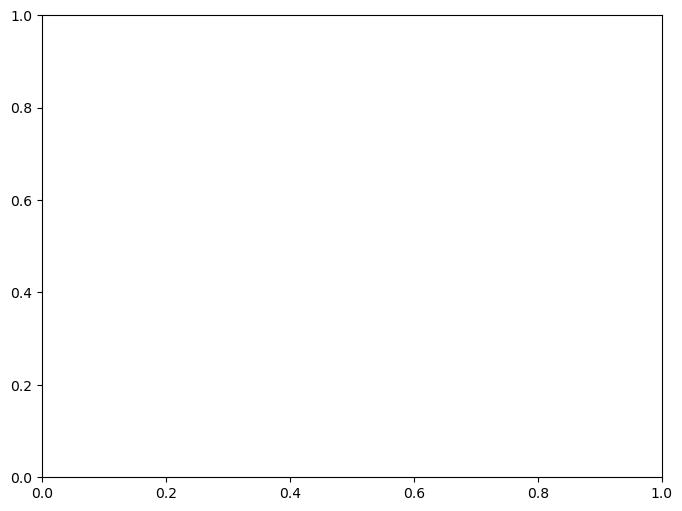

In [70]:
# # Correct the dimensions by trimming or creating midpoints
# frequency_bins_corrected = frequency_bins[:-1]  # Trim to match occurrence
# time_bins_corrected = time_bins[:-1]  # Trim to match occurrence
#
# # Plotting
# fig, ax = plt.subplots(figsize=(8, 6))
#
# # Adjust pcolormesh to align dimensions
# c = ax.pcolormesh(frequency_bins_corrected, time_bins_corrected, occurrence.T, shading='nearest', cmap='viridis')
# plt.colorbar(c, ax=ax, label='Occurrence')
#
# # Customize plot
# ax.set_title('Dynamic Period 02:37:00 - 02:37:30')
# ax.set_xlabel('Frequency (Hz)')
# ax.set_ylabel('Time')
# ax.grid(color='white', linestyle='--', linewidth=0.5)
#
# plt.tight_layout()
# plt.show()
